In [34]:
# Import necessary libraries
import optuna
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

# Scikit-Learn modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ignore warnings
warnings.filterwarnings("ignore")

# 1. Data Exploration

In [2]:
# loading the dataset
corn_df = pd.read_csv('/kaggle/input/imagoai-data/MLE-Assignment.csv')
corn_df.head()

,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0
2,imagoai_corn_2,0.389023,0.371206,0.373098,0.373872,0.361056,0.349709,0.333882,0.330841,0.328925,...,0.683054,0.669286,0.663179,0.676165,0.676591,0.655951,0.658945,0.670989,0.665176,1300.0
3,imagoai_corn_3,0.468837,0.473255,0.462949,0.459335,0.461672,0.459824,0.458194,0.427737,0.415360,...,0.742782,0.730801,0.736787,0.730044,0.751437,0.738497,0.742446,0.754657,0.733474,1300.0
4,imagoai_corn_4,0.483352,0.487274,0.469153,0.487648,0.464026,0.451152,0.458229,0.440782,0.426193,...,0.770227,0.773013,0.761431,0.763488,0.762473,0.744012,0.775486,0.760431,0.751988,220.0


In [3]:
corn_df.shape

(500, 450)

In [4]:
corn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(449), object(1)
memory usage: 1.7+ MB


In [5]:
corn_df.drop(columns=['hsi_id'], inplace=True)

In [6]:
corn_df.isnull().sum()

0                0
1                0
2                0
3                0
4                0
                ..
444              0
445              0
446              0
447              0
vomitoxin_ppb    0
Length: 449, dtype: int64

In [7]:
corn_df.duplicated().sum()

0

In [8]:
corn_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.443118,0.440761,0.433814,0.426122,0.418990,0.412432,0.405868,0.399815,0.394038,0.389664,...,0.741255,0.740818,0.740459,0.739758,0.739850,0.738738,0.738298,0.737599,0.738099,3410.006000
std,0.044719,0.045520,0.045764,0.046070,0.045405,0.044727,0.044528,0.043773,0.043659,0.043442,...,0.053479,0.053695,0.053812,0.053666,0.053487,0.053601,0.054014,0.054136,0.054297,13095.803483
min,0.311182,0.295321,0.284064,0.282054,0.296702,0.286860,0.262876,0.278523,0.255529,0.261459,...,0.562662,0.585011,0.558412,0.571735,0.575259,0.571767,0.577803,0.576985,0.562302,0.000000
25%,0.410456,0.404310,0.397038,0.389029,0.382102,0.377157,0.369620,0.364823,0.360634,0.355246,...,0.702105,0.703701,0.702988,0.700889,0.701690,0.700638,0.698655,0.698107,0.699673,137.500000
50%,0.449105,0.442651,0.434215,0.425074,0.417075,0.411872,0.405443,0.397917,0.393803,0.387211,...,0.743857,0.745922,0.745062,0.743991,0.744004,0.743965,0.743301,0.745216,0.745733,500.000000
75%,0.480245,0.478822,0.473158,0.464947,0.459232,0.452198,0.444384,0.438728,0.431165,0.427039,...,0.777884,0.776210,0.777069,0.774759,0.775698,0.775686,0.775621,0.774635,0.774310,1700.000000
max,0.556287,0.530168,0.528774,0.533202,0.511909,0.501786,0.504054,0.490692,0.489272,0.472080,...,0.940642,0.940361,0.939153,0.930366,0.942615,0.945225,0.932812,0.931381,0.957860,131000.000000


### **Data Exploration Summary**  

#### **1. Dataset Overview**  
- **Shape:** 500 rows × 450 columns (449 features + 1 target).  
- **Feature Type:** Spectral reflectance values measured at different wavelengths.  
- **Target Variable:** `vomitoxin_ppb` (continuous numerical value representing DON concentration).  
- **Data Quality:** No missing values or duplicate entries.  

#### **2. Target Variable Analysis (`vomitoxin_ppb`)**  
- **Distribution:** Highly skewed with extreme outliers.  
- **Statistics:**  
  - **Mean:** 3,410, **Std Dev:** 13,095 → high variance.  
  - **Min:** 0, **Max:** 131,000, **75th Percentile:** 1,700 → long-tailed distribution.  
- **Potential Actions:** Log transformation or outlier handling for better modeling.  

#### **3. Feature Statistics (`0` to `447`)**  
- **Range:** Mean values between **0.31 and 0.94**, Std Dev around **0.04 to 0.05** → consistent scale.  
- **Observations:** No extreme feature values, but **variance analysis** needed to drop redundant features.

# 2. Data Visualization

## *2.1 Feature Distribution*

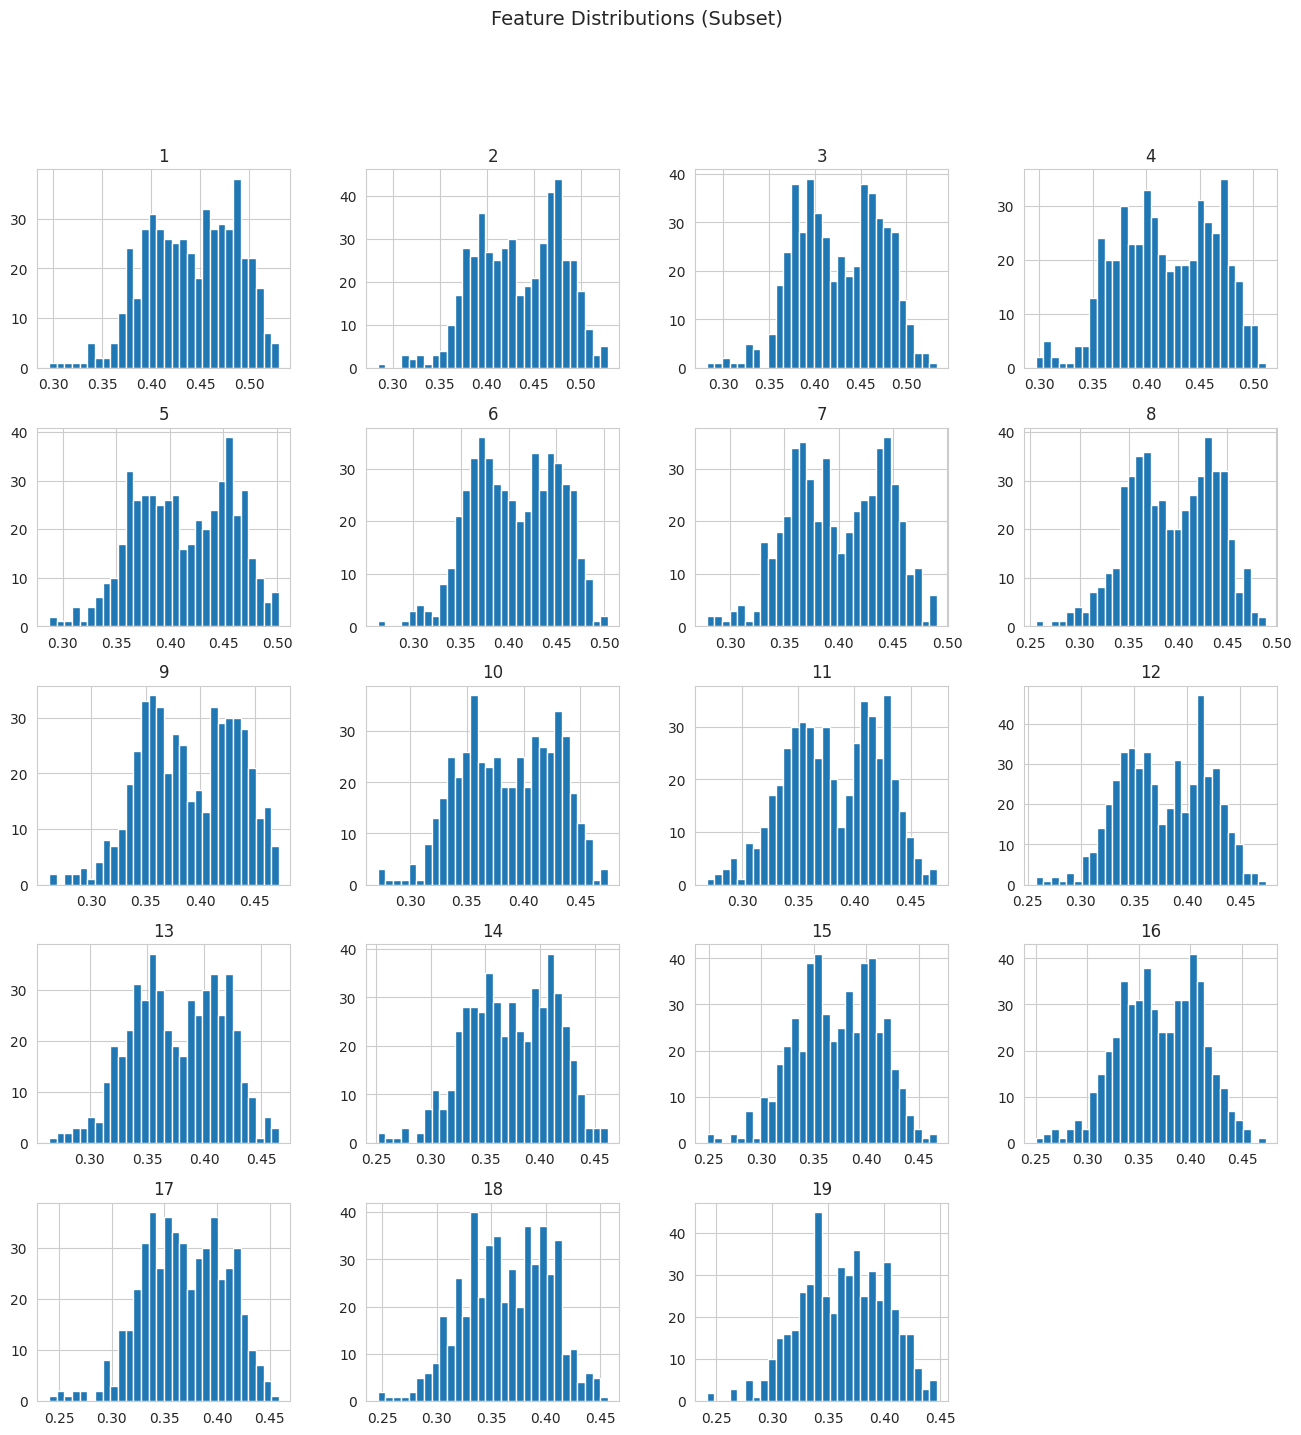

In [9]:
sns.set_style("whitegrid")
# Feature Distributions (Subset for better visibility)
corn_df.iloc[:, 1:20].hist(figsize=(16, 16), bins=30)
plt.suptitle("Feature Distributions (Subset)", fontsize=14)
plt.show()

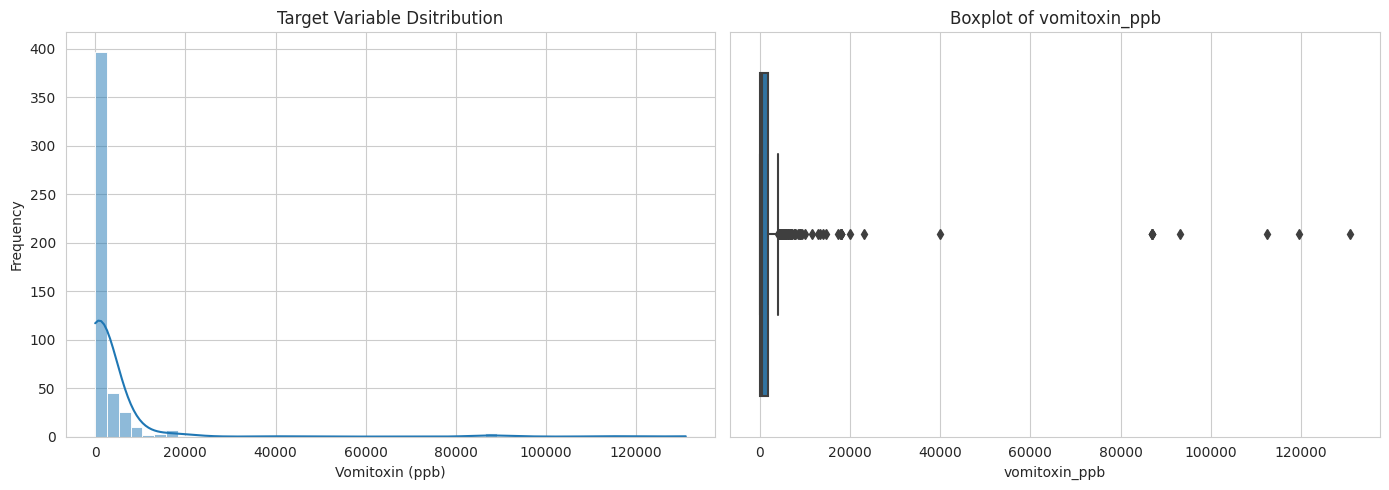

In [10]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# histogram
sns.histplot(corn_df["vomitoxin_ppb"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Target Variable Dsitribution")
axes[0].set_xlabel("Vomitoxin (ppb)")
axes[0].set_ylabel("Frequency")

# boxplot
sns.boxplot(x=corn_df["vomitoxin_ppb"], ax=axes[1])
axes[1].set_title("Boxplot of vomitoxin_ppb")

plt.tight_layout()
plt.show()

- *Feature distributions resemble a Gaussian-like shape.* 
- *A significant number of zero values are present in the histogram.*  
- *Some outliers are present and need to be addressed.*

## *2.2 Zero Count Analysis*

In [11]:
zero_count = (corn_df["vomitoxin_ppb"] == 0).sum()
zero_percentage = (zero_count / len(corn_df)) * 100
print(f"Zero values count: {zero_count}, Percentage: {zero_percentage:.2f}%")

Zero values count: 88, Percentage: 17.60%


In [12]:
corn_df[corn_df["vomitoxin_ppb"] == 0].describe()

,0,1,2,3,4,5,6,7,8,9,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,...,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.0
mean,0.452631,0.450272,0.443488,0.435162,0.428948,0.423573,0.415564,0.409516,0.403596,0.398601,...,0.743692,0.743627,0.744802,0.742347,0.743365,0.742841,0.740773,0.740968,0.742537,0.0
std,0.043950,0.045097,0.045383,0.044994,0.045261,0.046344,0.044214,0.045309,0.043560,0.043412,...,0.053375,0.051333,0.053922,0.052664,0.051740,0.052088,0.053439,0.053798,0.054361,0.0
min,0.315687,0.329597,0.316564,0.321215,0.317651,0.314776,0.304154,0.290678,0.300534,0.289619,...,0.592030,0.595265,0.583914,0.571735,0.606558,0.602188,0.577803,0.576985,0.585241,0.0
25%,0.416671,0.416822,0.414775,0.396872,0.395454,0.389450,0.380303,0.370772,0.368187,0.365523,...,0.706982,0.709034,0.709186,0.713371,0.707463,0.709882,0.707428,0.707304,0.702459,0.0
50%,0.463115,0.458302,0.450082,0.442997,0.433892,0.429291,0.425494,0.424846,0.406236,0.404730,...,0.748722,0.746625,0.752063,0.751209,0.752603,0.749439,0.748780,0.749422,0.750972,0.0
75%,0.487949,0.487699,0.478012,0.471476,0.469274,0.461384,0.455852,0.444323,0.441758,0.437599,...,0.783865,0.781049,0.783065,0.779439,0.780433,0.781471,0.779402,0.777750,0.779362,0.0
max,0.529865,0.523550,0.525140,0.533202,0.498973,0.496729,0.484997,0.474026,0.472149,0.468888,...,0.896055,0.882631,0.900531,0.903538,0.894678,0.895607,0.879744,0.889516,0.894756,0.0


In [13]:
corn_df[corn_df["vomitoxin_ppb"] > 0].describe()

,0,1,2,3,4,5,6,7,8,9,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
count,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,...,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000
mean,0.441086,0.438730,0.431748,0.424191,0.416863,0.410052,0.403798,0.397743,0.391997,0.387755,...,0.740735,0.740218,0.739532,0.739205,0.739099,0.737862,0.737770,0.736879,0.737152,4138.356796
std,0.044672,0.045407,0.045634,0.046120,0.045207,0.044068,0.044373,0.043212,0.043461,0.043262,...,0.053552,0.054227,0.053809,0.053925,0.053885,0.053940,0.054185,0.054245,0.054302,14324.760697
min,0.311182,0.295321,0.284064,0.282054,0.296702,0.286860,0.262876,0.278523,0.255529,0.261459,...,0.562662,0.585011,0.558412,0.582399,0.575259,0.571767,0.581650,0.585291,0.562302,10.000000
25%,0.408386,0.401718,0.394600,0.387685,0.380331,0.373545,0.368644,0.363616,0.358288,0.353053,...,0.699828,0.702522,0.701965,0.700266,0.700981,0.699849,0.697211,0.696501,0.699673,300.000000
50%,0.444662,0.440553,0.429965,0.422245,0.414265,0.408094,0.403975,0.395032,0.392324,0.385972,...,0.743343,0.745305,0.743785,0.743817,0.741831,0.743266,0.742841,0.744272,0.744548,710.000000
75%,0.476414,0.475980,0.470302,0.461855,0.457116,0.448257,0.442209,0.435756,0.428251,0.424913,...,0.777155,0.775156,0.775480,0.774365,0.775215,0.774262,0.775385,0.773622,0.773038,2625.000000
max,0.556287,0.530168,0.528774,0.518582,0.511909,0.501786,0.504054,0.490692,0.489272,0.472080,...,0.940642,0.940361,0.939153,0.930366,0.942615,0.945225,0.932812,0.931381,0.957860,131000.000000


### **Observations:**  
- **17.6%** of samples have `vomitoxin_ppb = 0`, indicating a true absence of contamination.    
- Variability in reflectance is consistent across both groups, suggesting no extreme feature differences.  
- The **long-tailed distribution** of `vomitoxin_ppb` in contaminated samples may require transformation for better modeling.

In [14]:
corn_df_filtered = corn_df

# 3. Model Preparation

## *3.1 Creating Feature Matrix (X) and Target Variable (y)*

In [15]:
X = corn_df_filtered.drop(columns=["vomitoxin_ppb"]) 
y = corn_df_filtered["vomitoxin_ppb"]

## *3.2 Train Test Split* 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (400, 448), Test shape: (100, 448)


In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test = scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# 4. Model Training

## 4.1 Linear Regression

In [19]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# predictions
lr_y_pred = lr_model.predict(X_test)

# evaluation
lr_mae = mean_absolute_error(y_test, lr_y_pred)
lr_rmse = mean_squared_error(y_test, lr_y_pred, squared=False)
lr_r2 = r2_score(y_test, lr_y_pred)

print("Linear Regression Results :-")
print(f"MAE: {lr_mae:.4f}, RMSE: {lr_rmse:.4f}, R² Score: {lr_r2:.4f}")

Linear Regression Results :-
MAE: 2.2117, RMSE: 2.7485, R² Score: -2.8846


## 4.2 Random Forest Regressor

In [20]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 15),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
    }

    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return mean_squared_error(y_test, y_pred)

In [21]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# train final model with best params
best_params = study.best_params
rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Results:")
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R² Score: {r2:.4f}")

[I 2025-03-17 17:37:51,891] A new study created in memory with name: no-name-8ee78041-979f-4838-ac29-ec926a2265a3
[I 2025-03-17 17:37:52,646] Trial 0 finished with value: 1.1805198773705043 and parameters: {'n_estimators': 319, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 1.1805198773705043.
[I 2025-03-17 17:37:53,563] Trial 1 finished with value: 1.2960714023096143 and parameters: {'n_estimators': 390, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 1.1805198773705043.
[I 2025-03-17 17:37:54,401] Trial 2 finished with value: 1.1958111450064957 and parameters: {'n_estimators': 454, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 1.1805198773705043.
[I 2025-03-17 17:37:55,162] Trial 3 finished with value: 1.0589896905218357 a

Random Forest Results:
MAE: 0.2863, RMSE: 0.8248, R² Score: 0.6502


## 4.3 XGBoost

In [22]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10)      
    }
    
    xgb = XGBRegressor(**params, random_state=42)
    xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20, verbose=False)
    
    y_pred = xgb.predict(X_test)
    return mean_squared_error(y_test, y_pred)  # Minimize RMSE

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best parameters & final model
best_params = study.best_params
print("Best Parameters:", best_params)

best_xgb = XGBRegressor(**best_params, random_state=42)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)

# Final Evaluation
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

[I 2025-03-17 17:38:28,439] A new study created in memory with name: no-name-bde461c6-4acd-41ef-a198-a95ba9d1511c
[I 2025-03-17 17:38:30,468] Trial 0 finished with value: 0.8683713221211226 and parameters: {'n_estimators': 440, 'learning_rate': 0.10091862971278229, 'max_depth': 10, 'subsample': 0.8311716738464338, 'colsample_bytree': 0.5416752476709199, 'reg_alpha': 6.1891970046850995, 'reg_lambda': 1.8013572500096553}. Best is trial 0 with value: 0.8683713221211226.
[I 2025-03-17 17:38:35,278] Trial 1 finished with value: 0.7979958840177326 and parameters: {'n_estimators': 255, 'learning_rate': 0.16016563398361502, 'max_depth': 10, 'subsample': 0.5786710272347253, 'colsample_bytree': 0.961975312318289, 'reg_alpha': 1.927691731161485, 'reg_lambda': 4.150128168177628}. Best is trial 1 with value: 0.7979958840177326.
[I 2025-03-17 17:38:46,599] Trial 2 finished with value: 0.9263830810387863 and parameters: {'n_estimators': 475, 'learning_rate': 0.01863551682650874, 'max_depth': 9, 'subs

Best Parameters: {'n_estimators': 349, 'learning_rate': 0.17072483839059333, 'max_depth': 8, 'subsample': 0.5302740460511732, 'colsample_bytree': 0.7828775791085428, 'reg_alpha': 3.7905674732629198, 'reg_lambda': 4.359775171506805}
MAE: 0.30384055344536
RMSE: 0.7942560198768993
R² Score: 0.675591932755446


In [23]:
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
xgb_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")

# Convert negative RMSE to positive
rf_rmse = -rf_scores.mean()
xgb_rmse = -xgb_scores.mean()

print("Random Forest Avg RMSE:", rf_rmse)
print("XGBoost Avg RMSE:", xgb_rmse)

Random Forest Avg RMSE: 0.8648761637642692
XGBoost Avg RMSE: 0.8133978551877531


In [24]:
print("Random Forest RMSE Std:", np.std(-rf_scores))
print("XGBoost RMSE Std:", np.std(-xgb_scores))

Random Forest RMSE Std: 0.3644965253983323
XGBoost RMSE Std: 0.3427668851207976


In [25]:
print("RF Train R²:", rf_model.score(X_train, y_train))
print("RF Test R²:", rf_model.score(X_test, y_test))

print("XGB Train R²:", best_xgb.score(X_train, y_train))
print("XGB Test R²:", best_xgb.score(X_test, y_test))

RF Train R²: 0.9833701908514303
RF Test R²: 0.6501812567191478
XGB Train R²: 0.9653629788009306
XGB Test R²: 0.675591932755446


### Model Selection

- **XGBoost is chosen for evaluation** as it has:  
  - Lower RMSE  
  - Higher standard deviation  
  - Better test R² vs. RandomForest

# 5. Visual Evaluation

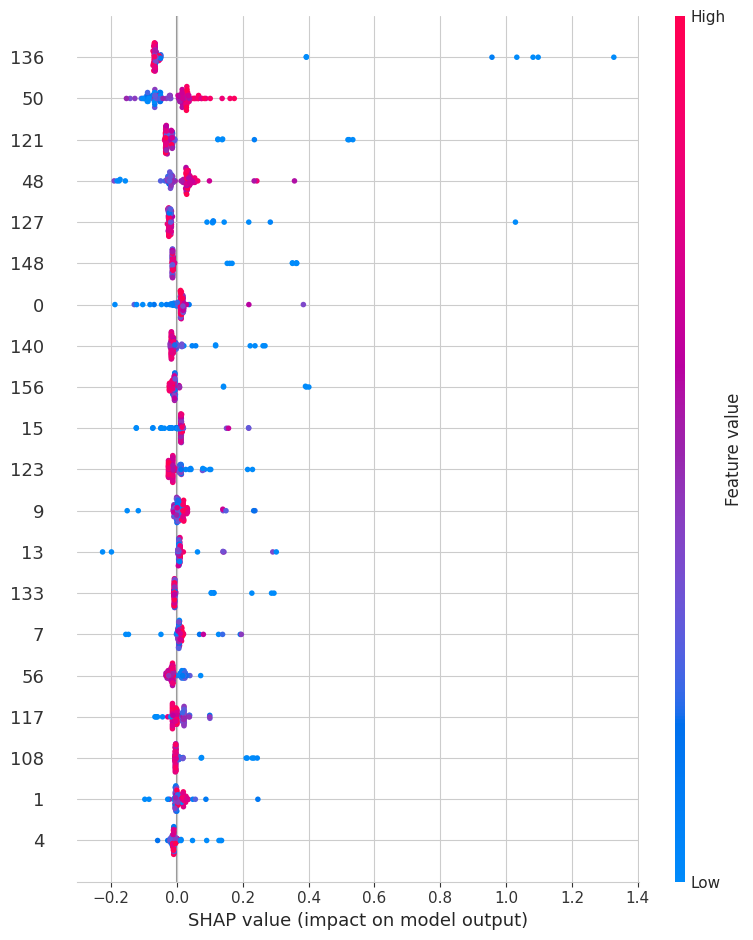

In [31]:
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

### SHAP Analysis Insights  

- SHAP values indicate the impact of features on predictions.  
- Some values are **close to zero**, meaning these features have little influence.  
- Others go as high as **1.3 or 1.2**, showing strong positive/negative effects.  
- A higher absolute SHAP value suggests a feature significantly affects the model’s prediction.  

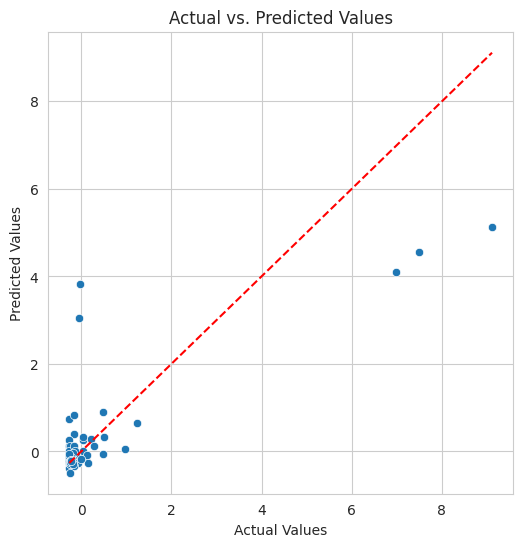

In [32]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")  # Ideal line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

### Actual vs. Predicted Insights  

- Most values are **clustered around zero and above it**, aligning well with the ideal line.  
- A few points **deviate significantly**, indicating potential model errors or outliers.  
- The overall trend suggests the model captures the general pattern but has some variance in predictions.

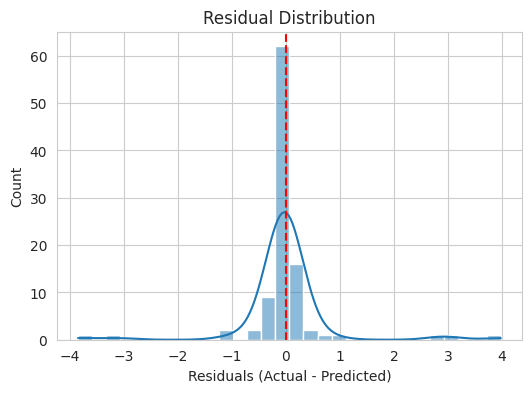

In [29]:
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color="red", linestyle="--")
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Residual Distribution")
plt.show()

### Residual Plot Insights  

- The residuals form a **bell-shaped curve**, suggesting that errors are **normally distributed**.  
- This indicates that the model's predictions are **unbiased** and the variance is **consistent** across predictions.  

In [35]:
with open("model.pkl", "wb") as f:
    pickle.dump(best_xgb, f)
print("XGB Model dumped sucessfully.")

XGB Model dumped sucessfully.
